In [ ]:
# Install Libraries
!pip install -qq transformers[torch] sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 26.1 MB/s eta 0:00:00


In [ ]:
# Import Libraries
import time
import json

import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
## make sure that gpu is available
torch.cuda.is_available()

True

In [ ]:
## First, upload your csv file using column on the left side (via folder icon -> upload button)
## After that, run this cell
path_file = '/content/Book5.csv'
df = pd.read_csv(path_file)
df = df.rename(columns={'sentence 1': 'sent1', 'sentence 2': 'sent2'})
df = df.dropna()   ### Some cells seem empty and cause error, fix them when you use
df['label'] = df['label'].replace({'P': 1, 'NP': 0})
df

,sent1,sent2,label
0,امریکا: یوې روسۍ جټ الوتکې د امریکا له بې پیلو...,امریکا وایی، د روسیې یوې الوتکې د امریکا د بې ...,1
1,د ميلي په وينا، تر اوسه معلومه نه ده، چې بريد ...,"میلي وویل چې هغه ""تر اوسه ډاډه نه دی"" چې ایا د...",1
2,په ترکیه کې د وروستیو زلزلو له امله تر سلو زیا...,په ترکیه کې د وروستۍ زلزلې له امله تر سلو زیات...,0
3,په سوریه کې یو نوی زیږیدلی ماشوم له خټو څخه ژو...,د ترکیې او سوریې د زلزلې له امله د مړو شمیر ۸۴...,1
4,دغه زلزله چې شدت یې د ریښتر په کچه ۵.۶ ښودل شو...,د 7.8 درجې زلزلې د دوشنبې په ورځ په داسې حال ک...,0
...,...,...,...
5788,د بدخشان ځینې سیمې زلزلې ولړزولې,د افغانستان په شمالي څنډو کې د بدخشان ځینې سیم...,1
5789,د امریکا د جیولوژۍ د سروې د موندنو له مخې د زل...,باختر دولتي اژانس چې د طالبانو په کنټرول کې دی...,0
5790,د راپور له مخې په فیض اباد، جرم، اشکاشم په سیم...,د طالبانو امنیتي کسان په سړکونو، لارو کوڅو او ...,0
5791,چا ته لا د زیانونو د رسېدو په اړه راپورونه نه ...,د ازادي راډیو اورېدونکو هم له بېلابېلو سیمو وی...,0


In [ ]:
## Download a tokenizer using the transformers library
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

In [ ]:
## Create dataset
# First split dataset into train/dev/test subset
num_train = 3000
num_dev = 1500
num_test = len(df) - num_train - num_dev

train_sent1 = df['sent1'].tolist()[:num_train]
train_sent2 = df['sent2'].tolist()[:num_train]
train_labels = df['label'].tolist()[:num_train]

dev_sent1 = df['sent1'].tolist()[num_train:num_train+num_dev]
dev_sent2 = df['sent2'].tolist()[num_train:num_train+num_dev]
dev_labels = df['label'].tolist()[num_train:num_train+num_dev]

test_sent1 = df['sent1'].tolist()[num_train+num_dev:]
test_sent2 = df['sent2'].tolist()[num_train+num_dev:]
test_labels = df['label'].tolist()[num_train+num_dev:]

In [ ]:
# Define Dataset Class
class PashtoPPDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
## Encode data
train_encodings = tokenizer(train_sent1, train_sent2, truncation=True, padding=True, max_length=256, return_tensors='pt')
dev_encodings = tokenizer(dev_sent1, dev_sent2, truncation=True, padding=True, max_length=256, return_tensors='pt')
test_encodings = tokenizer(test_sent1, test_sent2, truncation=True, padding=True, max_length=256, return_tensors='pt')

train_dataset = PashtoPPDataset(train_encodings, train_labels)
dev_dataset = PashtoPPDataset(dev_encodings, dev_labels)
test_dataset = PashtoPPDataset(test_encodings, test_labels)

In [ ]:
# Check tokenization
idx = 10

sent_1 = df['sent1'].tolist()[idx]
sent_2 = df['sent2'].tolist()[idx]
print('Raw Sentence 1 : ', sent_1)
print('Raw Sentence 2 : ', sent_2)
print('Tokenized Sentence Pair : ', [tokenizer.decode(x) for x in train_encodings['input_ids'][idx]])

Raw Sentence 1 :  طالبان زموږ د امنیت شورا خبرو ته نه دي رسېدلي
Raw Sentence 2 :  امنیت شورا: طالبانو زموږ هیلې نه دي پوره کړي
Tokenized Sentence Pair :  ['<s>', 'طالبان', 'زموږ', 'د', 'امنیت', 'شورا', 'خبرو', 'ته', 'نه', 'دي', 'رسېدل', 'ي', '</s>', '</s>', 'امنیت', 'شورا', ':', 'طالبانو', 'زموږ', 'هی', 'لې', 'نه', 'دي', 'پوره', 'کړي', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>

In [ ]:
# you can chenge these values and check the difference in outputs
batch_size = 32
num_epochs = 3
learning_rate = 2e-5

# Load Model
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=2)

# Define Arguments
training_args = TrainingArguments(
    per_device_train_batch_size=batch_size,
    num_train_epochs=num_epochs,
    logging_dir="./logs",
    logging_steps=5,
    output_dir="./output",
    evaluation_strategy="epoch",
)

# Define Optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Define Scheduler
num_training_steps = len(train_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Set Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    optimizers=(optimizer, scheduler),
)

# Start Fine Tuning
trainer.train()

<ipython-input-9-6a142e7dbb6a>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,0.326900,0.175063
2,0.304000,0.175697
3,0.138300,0.134903


TrainOutput(global_step=282, training_loss=0.33939563821182184, metrics={'train_runtime': 408.2988, 'train_samples_per_second': 22.043, 'train_steps_per_second': 0.691, 'total_flos': 1026749782440000.0, 'train_loss': 0.33939563821182184, 'epoch': 3.0})

In [ ]:
# Display loss per epoch
log_history = trainer.state.log_history

# just for formatting
for entry in log_history:
    if 'learning_rate' in entry:
        entry['learning_rate'] = format(entry['learning_rate'], '.5f')

log_history

[{'loss': 0.6668, 'learning_rate': '0.00002', 'epoch': 0.05, 'step': 5},
 {'loss': 0.7062, 'learning_rate': '0.00002', 'epoch': 0.11, 'step': 10},
 {'loss': 0.7112, 'learning_rate': '0.00002', 'epoch': 0.16, 'step': 15},
 {'loss': 0.7047, 'learning_rate': '0.00002', 'epoch': 0.21, 'step': 20},
 {'loss': 0.663, 'learning_rate': '0.00002', 'epoch': 0.27, 'step': 25},
 {'loss': 0.6628, 'learning_rate': '0.00002', 'epoch': 0.32, 'step': 30},
 {'loss': 0.5647, 'learning_rate': '0.00002', 'epoch': 0.37, 'step': 35},
 {'loss': 0.5376, 'learning_rate': '0.00002', 'epoch': 0.43, 'step': 40},
 {'loss': 0.4458, 'learning_rate': '0.00002', 'epoch': 0.48, 'step': 45},
 {'loss': 0.3314, 'learning_rate': '0.00002', 'epoch': 0.53, 'step': 50},
 {'loss': 0.35, 'learning_rate': '0.00002', 'epoch': 0.59, 'step': 55},
 {'loss': 0.3731, 'learning_rate': '0.00002', 'epoch': 0.64, 'step': 60},
 {'loss': 0.3044, 'learning_rate': '0.00002', 'epoch': 0.69, 'step': 65},
 {'loss': 0.2333, 'learning_rate': '0.0000

In [ ]:
## Check Result

# On trained data
prediction = trainer.predict(train_dataset)
predicted_labels = prediction.predictions.argmax(axis=1)
accuracy_train = (predicted_labels == train_labels).sum() / len(train_labels)
print()
print('### Train ###')
print('Predict Paraphrase : {}, Non-Paraphrase : {}'.format(sum(predicted_labels), len(predicted_labels)-sum(predicted_labels)))
print('Actual Paraphrase : {}, Non-Paraphrase : {}'.format(sum(train_labels), len(train_labels)-sum(train_labels)))
print('Accuracy : {:.4f}'.format(accuracy_train ))
print()

# On dev data
prediction = trainer.predict(dev_dataset)
predicted_labels = prediction.predictions.argmax(axis=1)
accuracy_dev = (predicted_labels == dev_labels).sum() / len(dev_labels)
print()
print('### Dev ###')
print('Predict Paraphrase : {}, Non-Paraphrase : {}'.format(sum(predicted_labels), len(predicted_labels)-sum(predicted_labels)))
print('Actual Paraphrase : {}, Non-Paraphrase : {}'.format(sum(dev_labels), len(dev_labels)-sum(dev_labels)))
print('Accuracy : {:.4f}'.format(accuracy_dev))
print()

# On test data
prediction = trainer.predict(test_dataset)
predicted_labels = prediction.predictions.argmax(axis=1)
accuracy_test = (predicted_labels == test_labels).sum() / len(test_labels)
print()
print('### Test ###')
print('Predict Paraphrase : {}, Non-Paraphrase : {}'.format(sum(predicted_labels), len(predicted_labels)-sum(predicted_labels)))
print('Actual Paraphrase : {}, Non-Paraphrase : {}'.format(sum(test_labels), len(test_labels)-sum(test_labels)))
print('Accuracy : {:.4f}'.format(accuracy_test))
print()


<ipython-input-21-6a142e7dbb6a>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}



### Train ###
Predict Paraphrase : 1321, Non-Paraphrase : 1679
Actual Paraphrase : 1308, Non-Paraphrase : 1692
Accuracy : 0.9410




### Dev ###
Predict Paraphrase : 960, Non-Paraphrase : 540
Actual Paraphrase : 972, Non-Paraphrase : 528
Accuracy : 0.9680




### Test ###
Predict Paraphrase : 797, Non-Paraphrase : 481
Actual Paraphrase : 796, Non-Paraphrase : 482
Accuracy : 0.9820



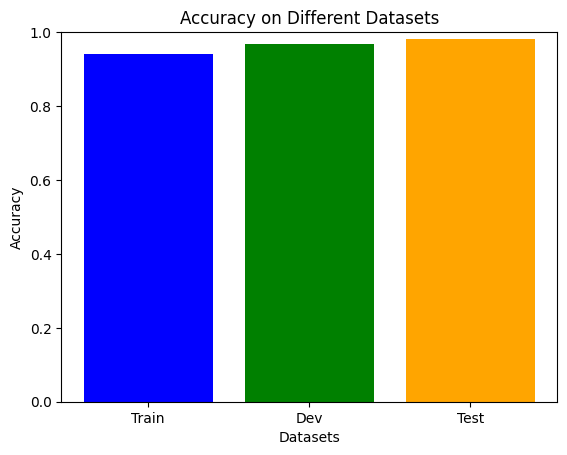

In [ ]:
!pip install matplotlib
import matplotlib.pyplot as plt

# Plotting the accuracies
labels = ['Train', 'Dev', 'Test']
accuracies = [accuracy_train, accuracy_dev, accuracy_test]

plt.bar(labels, accuracies, color=['blue', 'green', 'orange'])
plt.xlabel('Datasets')
plt.ylabel('Accuracy')
plt.title('Accuracy on Different Datasets')
plt.ylim(0, 1.0)  # Set the y-axis range from 0 to 1.0
plt.show()


In [ ]:
# Assuming you have defined 'test_dataset' and 'trainer'
test_preds_raw = trainer.predict(test_dataset).predictions


<ipython-input-21-6a142e7dbb6a>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [ ]:
from transformers import TrainingArguments
from sklearn.metrics import classification_report

# Assuming you have defined the 'test_labels' variable
test_preds = np.argmax(test_preds_raw, axis=-1)
print(classification_report(test_labels, test_preds, digits=3))


              precision    recall  f1-score   support

           0      0.977     0.975     0.976       482
           1      0.985     0.986     0.986       796

    accuracy                          0.982      1278
   macro avg      0.981     0.981     0.981      1278
weighted avg      0.982     0.982     0.982      1278



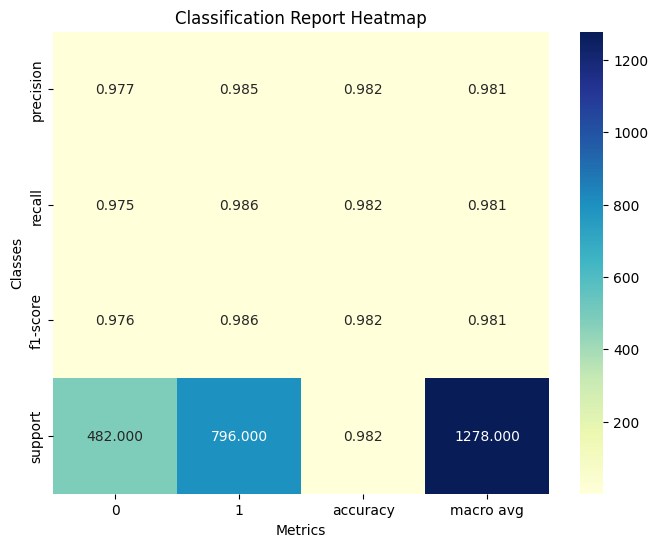

In [ ]:
from transformers import TrainingArguments
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have defined the 'test_dataset', 'trainer', and 'test_preds_raw' variables
test_preds = np.argmax(test_preds_raw, axis=-1)
report = classification_report(test_labels, test_preds, digits=3, output_dict=True)

# Convert the classification report dictionary to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Plot the classification report using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Classification Report Heatmap")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()
